<h1 style="text-align:center">Fraud Detection w/ Decision Tree</span>

## Assignment Notice
Use fraud data and build a decision tree model.

***

## 1. Preparing & Refining Data

In [31]:
import matplotlib.pyplot        as plt
import pandas                   as pd
from imblearn.over_sampling     import SMOTENC
from sklearn.metrics            import ConfusionMatrixDisplay
from sklearn.model_selection    import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import numpy as np

In [7]:
df_origin = pd.read_csv('../data/2_fraud_ex.csv')

잘못된 column명 수정 및 카테고리 수치화

In [8]:
df = df_origin.copy()
df.rename(columns = {'oldbalanceOrg':'oldbalanceOrig'}, inplace=True)
df = df[['type','amount','oldbalanceOrig', 'oldbalanceDest','newbalanceDest','isFraud']]
d = { 'CASH_IN': 0, 'CASH_OUT': 1, 'PAYMENT': 2, 'DEBIT': 3 }
df['type'] = df['type'].apply(lambda x: d.get(x, 4))
df.head()

,type,amount,oldbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,2,9839.64,170136.0,0.0,0.0,0
1,2,1864.28,21249.0,0.0,0.0,0
2,4,181.00,181.0,0.0,0.0,1
3,1,181.00,181.0,21182.0,0.0,1
4,2,11668.14,41554.0,0.0,0.0,0


데이터셋의 크기가 지나치게 크므로 10%만 사용

In [9]:
_, df_small, _, _ = train_test_split(df, df['isFraud'],
    test_size = 0.1, random_state=0, stratify=df['isFraud'])

In [10]:
df_small_backup = df_small.copy()

***

## 2. SMOTE를 이용한 불균형 해소

In [11]:
df_X = df_small.drop(columns='isFraud')
df_y = df_small.isFraud
df_small

,type,amount,oldbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
3719254,2,6160.39,0.00,0.00,0.00,0
3279306,0,316320.65,3890701.15,618799.45,302478.79,0
1641602,1,166964.42,0.00,243536.23,410500.65,0
1845883,2,6043.35,125894.50,0.00,0.00,0
3125087,2,11022.05,42039.00,0.00,0.00,0
...,...,...,...,...,...,...
6301803,4,117050.17,0.00,1166125.57,1283175.74,0
2591148,1,127019.75,432455.34,774931.13,901950.88,0
2137751,1,81754.37,0.00,1033822.94,1115577.31,0
5203113,1,31114.67,0.00,14410672.37,14441787.04,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, random_state=0, stratify=df_y)
sm = SMOTENC(categorical_features=[0], random_state=0, k_neighbors=7)
X_sm_train, y_sm_train = sm.fit_resample(X_train, y_train)

In [17]:
print(X_train.shape, X_sm_train.shape)
print(y_train.shape, y_sm_train.shape)

(477196, 5) (953160, 5)
(477196,) (953160,)


### MIN: Check the shape not for the entire train data set but for each class.

## 3. 결정 트리를 이용한 Fraud 분류

Train score: 1.000
Test score: 0.997


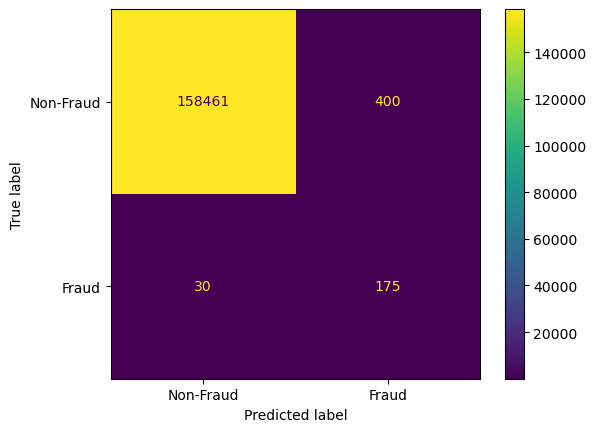

In [54]:
tree = DecisionTreeClassifier(random_state=0).fit(X_sm_train, y_sm_train)
print(f"Train score: {tree.score(X_sm_train, y_sm_train):.3f}")
print(f"Test score: {tree.score(X_test, y_test):.3f}")

ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
plt.show()

In [155]:
def print_error(a, b, c, d):
    print(f'Non-Fraud인데 Fraud로 예측한 비율: {b / (a+b):.2%}')
    print(f'Fraud인데 Non-Fraud로 예측한 비율: {c / (c+d):.2%}')
print_error(158461, 400, 30, 175)

Non-Fraud인데 Fraud로 예측한 비율: 0.25%
Fraud인데 Non-Fraud로 예측한 비율: 14.63%


Score도 큰 문제가 없고, CMD 그래프도 큰 문제가 없어보임.

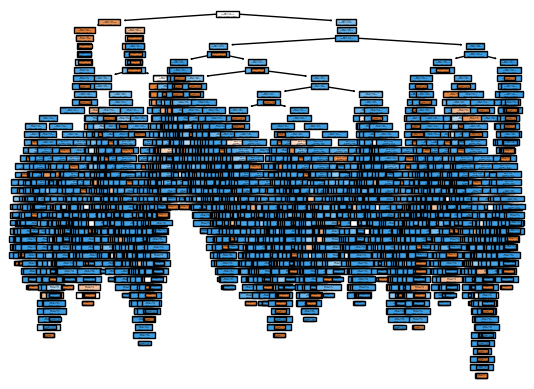

In [48]:
plot_tree(tree, feature_names=df_X.columns, filled=True)
plt.show()

다만 위를 보면 지나칠 정도로 Overfitting 된 느낌이 있음.\
하이퍼파라미터를 조금씩 조정하며 더 나은 모델을 찾아봄.

Train score: 0.987
Test score: 0.978


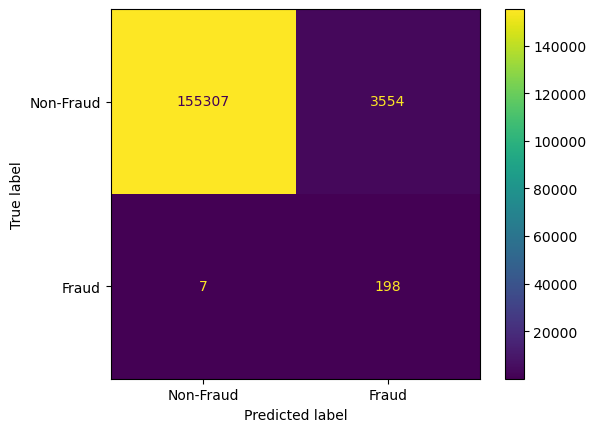

In [81]:
tree = DecisionTreeClassifier(min_samples_leaf=965, random_state=0).fit(X_sm_train, y_sm_train)
print(f"Train score: {tree.score(X_sm_train, y_sm_train):.3f}")
print(f"Test score: {tree.score(X_test, y_test):.3f}")

ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
plt.show()

In [156]:
print_error(155307, 3554, 7, 198)

Non-Fraud인데 Fraud로 예측한 비율: 2.24%
Fraud인데 Non-Fraud로 예측한 비율: 3.41%


min_samples_leaf를 10, 20, 30, ..., 100, 200, ..., 1000, 2000, ...으로 테스트한 결과,\
1000 부근에서 'Fraud를 Non-Fraud로 잘못 예측한 경우'가 가장 적었음.

현재 이 데이터셋은 **사기거래를 감지하는 것이 목적** 이므로,\
Non-Fraud를 Fraud로 잘못 예측(1종 오류)한 사례보다 **Fraud 데이터를 Non-Fraud로 잘못 예측(2종 오류)** 한\
사례를 줄이는 것이 더 중요하다고 판단함.

- 1종 오류: 2%
- 2종 오류: 3%

이에 따라 Test score에서 약간의 희생을 보더라도 CMD Matrix의 좌하단 값을 0에 가깝게 만드는 것을 최우선으로 한다.

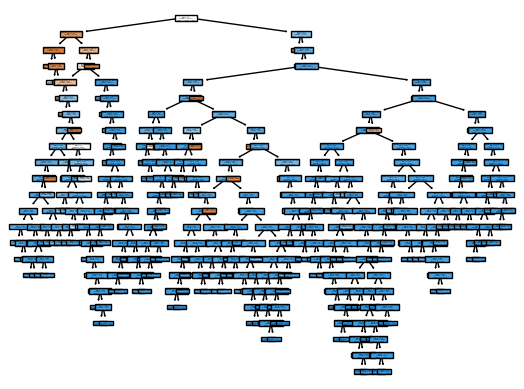

In [82]:
plot_tree(tree, feature_names=df_X.columns, filled=True)
plt.show()

```min_samples_leaf=965``` 일 때, 확실히 트리가 덜 빽빽해짐을 확인함.

Train score: 0.973
Test score: 0.947


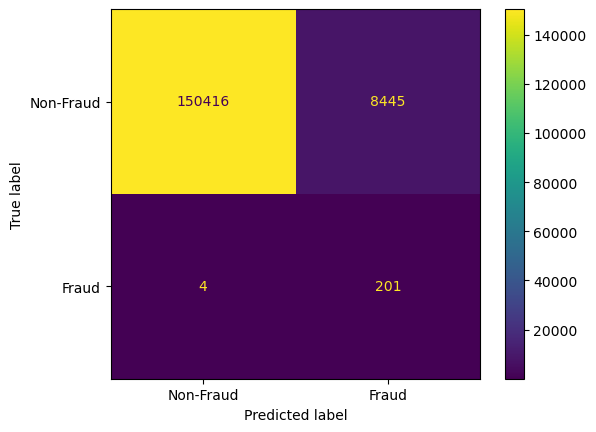

In [175]:
tree = DecisionTreeClassifier(max_depth=6, random_state=0).fit(X_sm_train, y_sm_train)
print(f"Train score: {tree.score(X_sm_train, y_sm_train):.3f}")
print(f"Test score: {tree.score(X_test, y_test):.3f}")

ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
plt.show()

In [157]:
print_error(150416, 8445, 4, 201)

Non-Fraud인데 Fraud로 예측한 비율: 5.32%
Fraud인데 Non-Fraud로 예측한 비율: 1.95%


```max_depth=6``` 인 경우 2종 오류의 비율이 1.9%까지 감소함. 다만 1종 오류의 비율은 5%로 소폭 상승함.

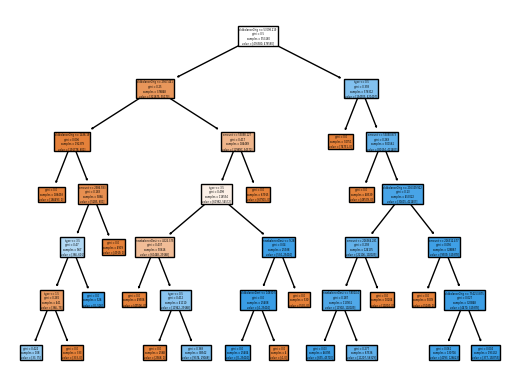

In [176]:
plot_tree(tree, feature_names=df_X.columns, filled=True)
plt.show()

### min_samples_leaf와 max_depth를 동시에 조정해보자.
정답이 없으니 일일이 두 값을 조절하면서 차이를 비교한다.

Train score: 0.976
Test score: 0.953


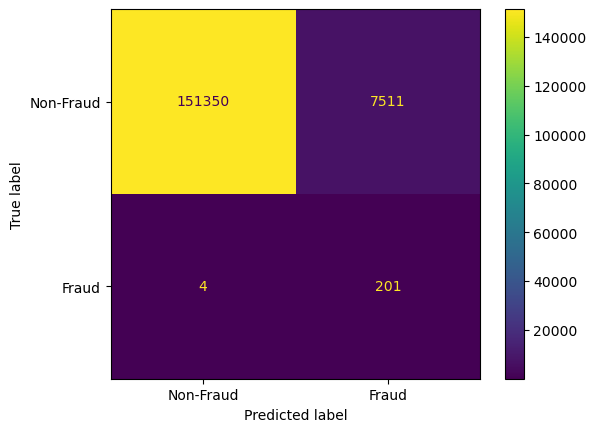

In [177]:
tree = DecisionTreeClassifier(min_samples_leaf=500, max_depth=7, random_state=0).fit(X_sm_train, y_sm_train)
print(f"Train score: {tree.score(X_sm_train, y_sm_train):.3f}")
print(f"Test score: {tree.score(X_test, y_test):.3f}")

ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
plt.show()

In [158]:
print_error(151350, 7511, 4, 201)

Non-Fraud인데 Fraud로 예측한 비율: 4.73%
Fraud인데 Non-Fraud로 예측한 비율: 1.95%


2종오류는 유지하면서 1종오류가 소폭 줄었다. (4.7%)\
여기서 max_depth가 7보다 작아지는 경우에는 무슨 수를 써도 2종오류가 줄지 않고,\
오히려 1종 오류가 늘기만 했다.

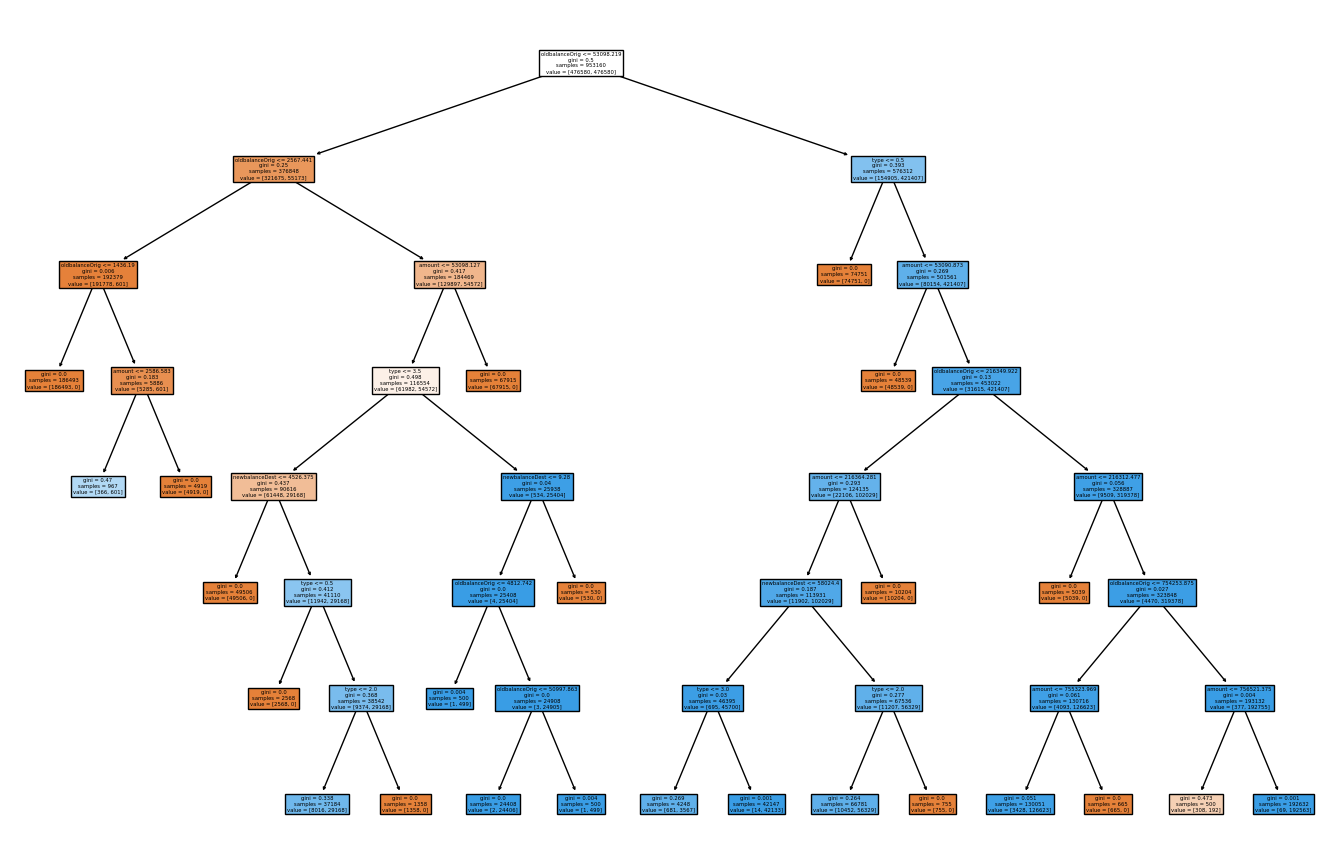

In [181]:
plt.figure(figsize=(17, 11))
plot_tree(tree, feature_names=df_X.columns, filled=True)
plt.show()

(-1.0, 5.0)

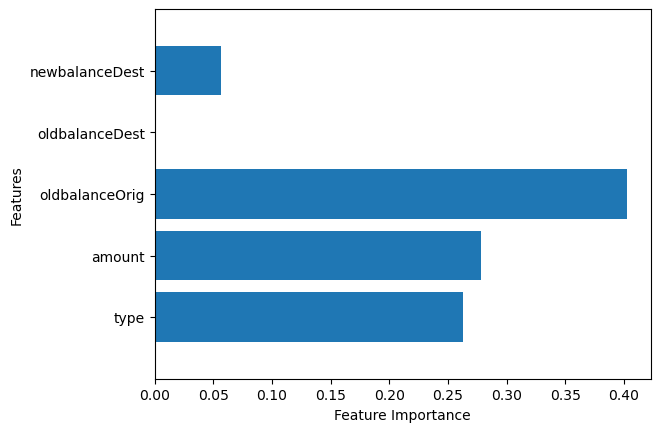

In [183]:
n_features = len(df_X.columns)
plt.barh(np.arange(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), df_X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.ylim(-1, n_features)

송신자의 기존 잔고가 가장 중요한 지표로 쓰였음을 확인할 수 있음.\
그 다음으로 거래액, 거래 유형, 수신자의 잔고가 중요하게 작용하였으며,\
송신자의 기존 잔고는 영향을 미치지 않았음.